# Logistic Regression (Juices dataset)

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Load raw data and plot

In [3]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/juices/FTIR_juices.csv')
data.head(5)

,899.327,903.187,907.047,910.907,914.767,918.627,922.487,926.347,930.207,934.067,...,1771.684,1775.544,1779.404,1783.264,1787.124,1790.984,1794.844,1798.704,1802.564,label
0,0.002806,0.002732,0.002661,0.002657,0.002699,0.002762,0.002749,0.002686,0.002637,0.002617,...,0.000348,0.000216,0.000166,0.000117,0.000087,0.000046,0.000011,0.000009,0.000009,NON-Strawberry
1,0.002637,0.002638,0.002651,0.002757,0.003000,0.003313,0.003412,0.003302,0.003162,0.003060,...,0.000013,0.000006,-0.000005,-0.000005,-0.000006,0.000002,0.000010,0.000005,0.000005,NON-Strawberry
2,0.002416,0.002480,0.002511,0.002611,0.002802,0.003031,0.003235,0.003316,0.003257,0.003136,...,0.000290,0.000185,0.000137,0.000090,0.000062,0.000031,0.000009,0.000007,0.000007,NON-Strawberry
3,0.002345,0.002292,0.002249,0.002303,0.002466,0.002642,0.002703,0.002671,0.002618,0.002567,...,0.000419,0.000267,0.000179,0.000119,0.000075,0.000043,0.000021,0.000008,0.000008,NON-Strawberry
4,0.002303,0.002342,0.002350,0.002419,0.002561,0.002737,0.002862,0.002860,0.002811,0.002750,...,0.000468,0.000299,0.000212,0.000140,0.000099,0.000054,0.000020,0.000012,0.000012,NON-Strawberry


In [4]:
# shuffle data rows
data = data.sample(frac=1)

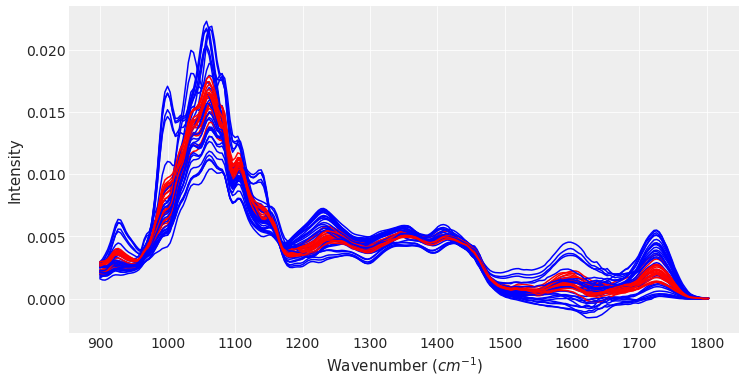

In [5]:
# number of non-data columns at right of dataframe
ndata_cols = -1

# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity')

for i in range(50):
    y_val = data.values[i]
    if y_val[-1] == 'NON-Strawberry':
        col = 'blue'
    else:
        col = 'red'
    plt.plot(x_val, y_val[:ndata_cols], '-', color=col);

In [6]:
# number of samples from each class
data['label'].value_counts()

NON-Strawberry    632
Strawberry        351
Name: label, dtype: int64

In [7]:
# generate training and test sets
train_data, test_data = train_test_split(data, test_size=0.33, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [8]:
test_data.shape

(325, 236)

In [9]:
train_data.shape

(658, 236)

# Model definition (Multiple Logistic Regression)
The following statistical model is assumed:

\begin{equation}
\alpha \sim \mathcal{N}(\mu_{\alpha},\,\sigma^{2}_{\alpha}) \\
\beta \sim \mathcal{N}(\mu_{\beta},\,\sigma^{2}_{\beta}) \\
\theta = logistic(\alpha+\beta X) \\
y \sim Bernoulli(\theta)
\end{equation}

In [10]:
# standardize data
Y = pd.Categorical(train_data['label']).codes
x_n = train_data.columns[:ndata_cols]
x_s = train_data[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)
x_s.shape

(658, 235)

In [11]:
with pm.Model() as model_mlr: 
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 
 
    trace_mlr = pm.sample(2000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [1:11:25<00:00,  1.17draws/s]


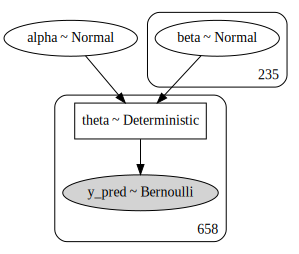

In [12]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [13]:
varnames = ['alpha', 'beta']
coef = az.summary(trace_mlr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-20.954,3.154,-26.812,-14.963,0.056,0.040,3196.0,3080.0,3272.0,2697.0,1.0
beta[0],-2.088,7.123,-15.344,10.978,0.106,0.112,4542.0,2040.0,4548.0,2937.0,1.0
beta[1],-5.458,7.908,-21.152,8.439,0.115,0.105,4701.0,2817.0,4678.0,2794.0,1.0
beta[2],-3.188,8.436,-18.610,13.141,0.103,0.135,6748.0,1951.0,6864.0,2795.0,1.0
beta[3],0.323,8.591,-16.200,16.195,0.100,0.150,7308.0,1635.0,7347.0,2962.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta[230],-2.476,7.972,-17.247,12.592,0.114,0.125,4858.0,2048.0,4848.0,2969.0,1.0
beta[231],-6.070,7.144,-19.581,7.397,0.105,0.092,4628.0,3001.0,4658.0,3216.0,1.0
beta[232],-9.858,5.857,-20.468,1.461,0.093,0.071,3965.0,3435.0,3962.0,2541.0,1.0
beta[233],-11.993,4.911,-21.487,-3.055,0.089,0.066,3032.0,2756.0,3097.0,2662.0,1.0


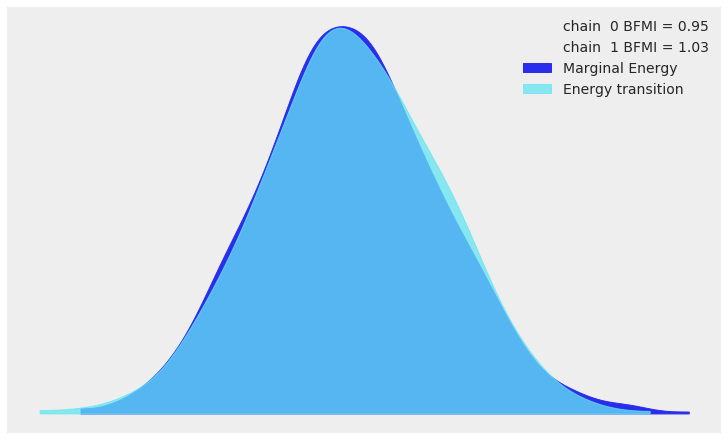

In [14]:
#az.plot_forest(trace_mlr, var_names=varnames, combined=True);
az.plot_energy(trace_mlr, figsize=(10, 6));

In [15]:
# check model predictions on test dataset
a = trace_mlr['alpha'].mean()
b = trace_mlr['beta'].mean(axis=0)

xt_n = test_data.columns[:ndata_cols]
xt_s = test_data[x_n].values
xt_s = (xt_s - xt_s.mean(axis=0)) / xt_s.std(axis=0)

mu_t = a + (b * xt_s).sum(axis=1)
yt_p = 1 / (1 + np.exp(-mu_t))

pt_y = np.zeros(len(xt_s))
lp_t = [] 

for i in range(len(xt_s)):
    if (yt_p[i] < 0.5): 
        pt_y[i] = 0
        lp_t.append('NON-Strawberry')
    else:
        pt_y[i] = 1
        lp_t.append('Strawberry')
        
test_data = test_data.assign(pred=pd.Series(pt_y))
test_data = test_data.assign(pred_label=pd.Series(lp_t))
test_data.iloc[:,(ndata_cols-2):]

,label,pred,pred_label
0,Strawberry,1.0,Strawberry
1,NON-Strawberry,0.0,NON-Strawberry
2,NON-Strawberry,0.0,NON-Strawberry
3,NON-Strawberry,0.0,NON-Strawberry
4,Strawberry,1.0,Strawberry
...,...,...,...
320,NON-Strawberry,0.0,NON-Strawberry
321,NON-Strawberry,0.0,NON-Strawberry
322,Strawberry,1.0,Strawberry
323,NON-Strawberry,0.0,NON-Strawberry


In [16]:
# prediction score on test dataset (%)
Yt = pd.Categorical(test_data['label']).codes
c = 0
for i in range(len(xt_s)):
    if test_data['label'].iloc[i] == lp_t[i]:
        c += 1
        
f'{c/len(Yt) * 100:.1f}'

'98.2'